# Importing libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score,ConfusionMatrixDisplay
import seaborn as sn
import pathlib
import os
from os import listdir
import glob
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    MaxPool2D,
    Flatten,
    Dropout,
    BatchNormalization,
    LayerNormalization,
    AveragePooling2D,
    Normalization
)

cinic_directory_train = 'D:\\GitHub\\CINIC-10\\train' #'D:\\GitHub\\cinic-10_image_classification_challenge-dataset\\train'
cinic_directory_test = 'D:\\GitHub\\CINIC-10\\test' #'D:\\GitHub\\cinic-10_image_classification_challenge-dataset\\test'
cinic_directory_val = 'D:\\GitHub\\CINIC-10\\valid'

tf.random.set_seed(1337)

optimiser='adamax'
batch_size_choice=16
image_size=(32, 32)
loss_func='categorical_crossentropy'
metrics=['categorical_accuracy','AUC','Precision','Recall'] #można potem obliczyć F1 na podstawie recall i precision
metrics2 = ['categorical_accuracy','auc','precision','recall']

# Helping functions

In [2]:
def show_training_validation_loss_and_metrics(model,metrics):
    f,ax=plt.subplots(2,1,figsize=(20,20)) 

    #Assigning the first subplot to graph training loss and validation loss
    ax[0].plot(model.history.history['loss'],color='b',label='Training Loss')
    ax[0].plot(model.history.history['val_loss'],color='r',label='Validation Loss')

    #Plotting the training accuracy and validation accuracy
    for metric in metrics:
        ax[1].plot(model.history.history[metric],label='Training '+metric)
        ax[1].plot(model.history.history['val_'+metric],label='Validation '+metric)

    plt.legend() 

In [3]:
def show_confusion_matrix(model, test_ds, num_classes, class_names):
    true_labels = np.concatenate([y for x, y in test_ds], axis=0)
    tf_labels = tf.argmax(true_labels, axis=1).numpy()

    predictions = model.predict(test_ds)
    predicted_classes = np.argmax(predictions, axis=1)

    conf_matrix = tf.math.confusion_matrix(tf_labels, predicted_classes, num_classes=num_classes)

    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix.numpy(), display_labels=class_names)
    fig, ax = plt.subplots(figsize=(11, 9))  # Ustaw rozmiar wykresu na 10x8

    # Wyświetl macierz pomyłek z określonym rozmiarem
    disp.plot(ax=ax)  # Użyj parametru ax, aby użyć określonej osi
    plt.show()
    return

# Data loading

In [4]:
# loading in the data 
train_ds = keras.preprocessing.image_dataset_from_directory(
    cinic_directory_train,
    image_size=image_size,
    batch_size=batch_size_choice,
    label_mode = "categorical"
)

Found 90000 files belonging to 10 classes.


In [5]:
# loading in the data 
validation_ds = keras.preprocessing.image_dataset_from_directory(
    cinic_directory_val,
    image_size=image_size,
    batch_size=batch_size_choice,
    label_mode = "categorical"
)

Found 90000 files belonging to 10 classes.


In [6]:
test_ds = keras.preprocessing.image_dataset_from_directory(
    cinic_directory_test,
    image_size=image_size,
    batch_size=batch_size_choice,
    label_mode = "categorical"
)

Found 90000 files belonging to 10 classes.


In [7]:
class_names= train_ds.class_names
num_classes = len(class_names)
print(class_names)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [8]:
# Normalize all data
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
validation_ds = validation_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

In [16]:
true_labels = np.concatenate([y for x, y in test_ds], axis=0)
tf_labels = tf.argmax(true_labels, axis=1).numpy()

# First model architecture

In [10]:
def create_Architecture1():
    model = Sequential([
        Conv2D(256, kernel_size=(3, 3), strides=1, padding='same', activation='relu', input_shape=(32,32,3)),
        BatchNormalization(),
        MaxPool2D((2, 2), strides=2, padding="same"),
        Conv2D(128, (3, 3), strides=1, padding="same", activation="relu"),
        BatchNormalization(),
        MaxPool2D((2, 2), strides=2, padding="same"),
        Dropout(0.2),
        Conv2D(64, (3, 3), strides=1, padding="same", activation="relu"),
        BatchNormalization(),
        MaxPool2D((2, 2), strides=2, padding="same"),
        Conv2D(32, (3, 3), strides=1, padding="same", activation="relu"),
        BatchNormalization(),
        MaxPool2D((2, 2), strides=2, padding="same"),
        Flatten(),
        Dense(units=512),
        Dropout(0.3),
        Dense(units=num_classes, activation="softmax")
    ])
    return model

In [11]:
model1 = create_Architecture1()

In [12]:
model1.compile( 
    loss=loss_func,
    metrics=metrics
)

In [13]:
model1.summary()

In [14]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
history = model1.fit(
    train_ds,
    validation_data=validation_ds, 
    epochs=20,
    callbacks = [callback]
)

Epoch 1/20
5625/5625 [==============================] - 98s 16ms/step - loss: 1.5213 - categorical_accuracy: 0.4524 - auc: 0.8671 - precision: 0.6231 - recall: 0.2751 - val_loss: 1.5315 - val_categorical_accuracy: 0.4613 - val_auc: 0.8683 - val_precision: 0.6155 - val_recall: 0.3111
Epoch 2/20
5625/5625 [==============================] - 86s 15ms/step - loss: 1.2089 - categorical_accuracy: 0.5650 - auc: 0.9167 - precision: 0.7164 - recall: 0.4130 - val_loss: 1.3813 - val_categorical_accuracy: 0.5117 - val_auc: 0.8940 - val_precision: 0.6530 - val_recall: 0.3893
Epoch 3/20
5625/5625 [==============================] - 87s 15ms/step - loss: 1.1041 - categorical_accuracy: 0.6073 - auc: 0.9305 - precision: 0.7432 - recall: 0.4721 - val_loss: 1.3475 - val_categorical_accuracy: 0.5249 - val_auc: 0.9004 - val_precision: 0.6538 - val_recall: 0.4152
Epoch 4/20
5625/5625 [==============================] - 88s 16ms/step - loss: 1.0293 - categorical_accuracy: 0.6337 - auc: 0.9396 - precision: 0.756

In [15]:
result=model1.evaluate(test_ds)

5625/5625 [==============================] - 32s 6ms/step - loss: 1.0817 - categorical_accuracy: 0.6329 - auc: 0.9356 - precision: 0.7183 - recall: 0.5605


5625/5625 [==============================] - 25s 4ms/step


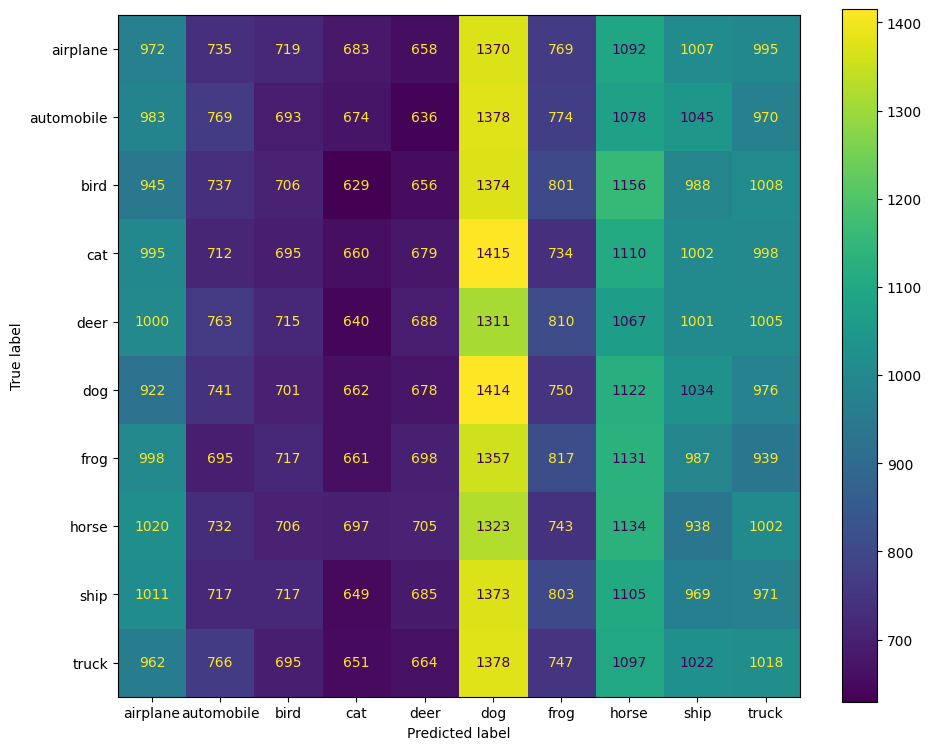

In [18]:
show_confusion_matrix(model1,test_ds,num_classes,class_names)

# Second model architecture

In [19]:
def create_Architecture2():
    model = Sequential([
        Conv2D(75, (3, 3), strides=1, padding="same", activation="relu", 
                 input_shape=(32, 32, 3)),
        LayerNormalization(),
        AveragePooling2D((2, 2), strides=2, padding="same"),
        Conv2D(50, (3, 3), strides=1, padding="same", activation="relu"),
        LayerNormalization(),
        AveragePooling2D((2, 2), strides=2, padding="same"),
        Conv2D(25, (3, 3), strides=1, padding="same", activation="relu"),
        LayerNormalization(),
        AveragePooling2D((2, 2), strides=2, padding="same"),
        LayerNormalization(),
        Flatten(),
        Dense(units=512),
        Dense(units=num_classes, activation="softmax")
    ])
    return model

In [20]:
model2 = create_Architecture2()

model2.compile( 
    loss=loss_func,
    metrics=metrics
)

In [ ]:
model2.summary()

In [21]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
history = model2.fit(
    train_ds,
    validation_data=validation_ds, 
    epochs=20, 
    callbacks = [callback]
)

Epoch 1/20
5625/5625 [==============================] - 78s 14ms/step - loss: 1.7192 - categorical_accuracy: 0.3747 - auc: 0.8232 - precision: 0.5995 - recall: 0.1491 - val_loss: 1.4477 - val_categorical_accuracy: 0.4654 - val_auc: 0.8791 - val_precision: 0.6606 - val_recall: 0.2577
Epoch 2/20
5625/5625 [==============================] - 76s 14ms/step - loss: 1.3856 - categorical_accuracy: 0.4960 - auc: 0.8895 - precision: 0.6896 - recall: 0.3003 - val_loss: 1.3372 - val_categorical_accuracy: 0.5142 - val_auc: 0.8974 - val_precision: 0.6911 - val_recall: 0.3478
Epoch 3/20
5625/5625 [==============================] - 75s 13ms/step - loss: 1.2773 - categorical_accuracy: 0.5389 - auc: 0.9068 - precision: 0.7124 - recall: 0.3618 - val_loss: 1.2817 - val_categorical_accuracy: 0.5325 - val_auc: 0.9069 - val_precision: 0.6824 - val_recall: 0.3972
Epoch 4/20
5625/5625 [==============================] - 81s 14ms/step - loss: 1.2141 - categorical_accuracy: 0.5626 - auc: 0.9160 - precision: 0.724

In [22]:
model2.evaluate(test_ds)

5625/5625 [==============================] - 30s 5ms/step - loss: 1.1367 - categorical_accuracy: 0.6059 - auc: 0.9284 - precision: 0.7074 - recall: 0.5144


[1.1367167234420776,
 0.6058666706085205,
 0.9283724427223206,
 0.7074076533317566,
 0.5144110918045044]

5625/5625 [==============================] - 21s 4ms/step


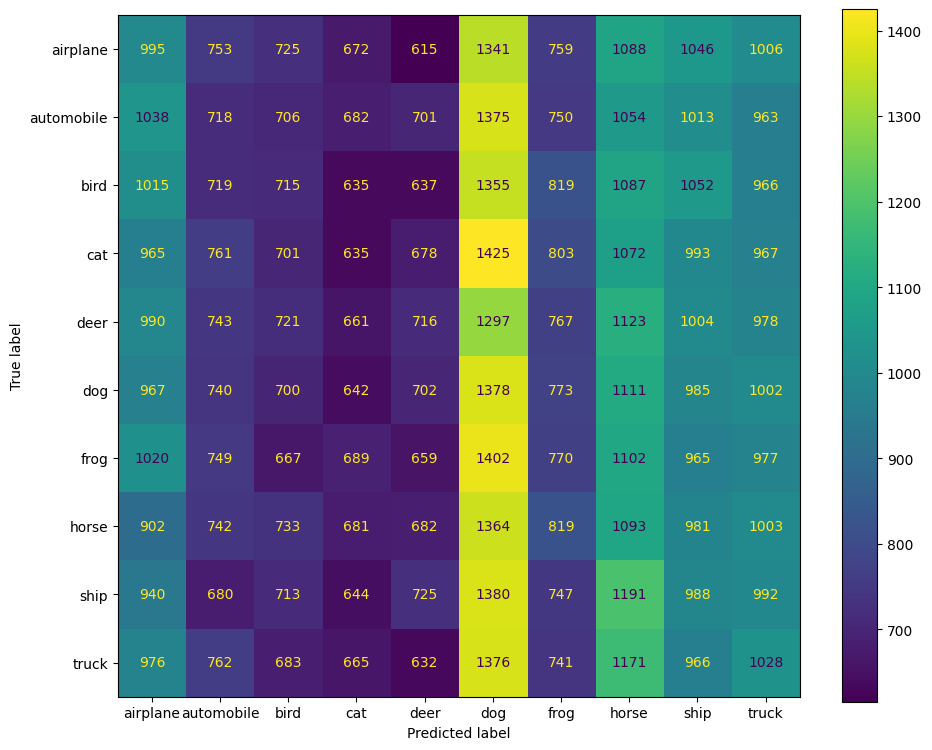

In [24]:
show_confusion_matrix(model1,test_ds,num_classes,class_names)

# Third model architecture

In [25]:
def create_Architecture3():
    model = Sequential([
        Conv2D(256, (3, 3), strides=1, padding="same", activation="sigmoid", 
                 input_shape=(32, 32, 3)),
        LayerNormalization(),
        MaxPool2D((2, 2), strides=2, padding="same"),
        Conv2D(128, (3, 3), strides=1, padding="same", activation="sigmoid"),
        LayerNormalization(),
        MaxPool2D((2, 2), strides=2, padding="same"),
        Dropout(0.2),
        Conv2D(64, (3, 3), strides=1, padding="same", activation="sigmoid"),
        LayerNormalization(),
        MaxPool2D((2, 2), strides=2, padding="same"),
        Conv2D(32, (3, 3), strides=1, padding="same", activation="sigmoid"),
        LayerNormalization(),
        MaxPool2D((2, 2), strides=2, padding="same"),
        Conv2D(16, (3, 3), strides=1, padding="same", activation="sigmoid"),
        LayerNormalization(),
        MaxPool2D((2, 2), strides=2, padding="same"),
        Flatten(),
        Dense(units=1024),
        Dropout(0.3),
        Dense(units=num_classes, activation="softmax")
    ])
    return model


In [26]:
model3 = create_Architecture3()

model3.compile( 
    optimizer=optimiser,
    loss=loss_func,
    metrics=metrics
)

model3.summary()

In [27]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
history = model3.fit(
    train_ds,
    validation_data=validation_ds, 
    epochs=20, 
    callbacks = [callback]
)

Epoch 1/20
5625/5625 [==============================] - 80s 14ms/step - loss: 1.6537 - categorical_accuracy: 0.3767 - auc: 0.8365 - precision: 0.6241 - recall: 0.1396 - val_loss: 1.5505 - val_categorical_accuracy: 0.4306 - val_auc: 0.8608 - val_precision: 0.6287 - val_recall: 0.2065
Epoch 2/20
5625/5625 [==============================] - 77s 14ms/step - loss: 1.3668 - categorical_accuracy: 0.4952 - auc: 0.8929 - precision: 0.6888 - recall: 0.2991 - val_loss: 1.2792 - val_categorical_accuracy: 0.5307 - val_auc: 0.9068 - val_precision: 0.7192 - val_recall: 0.3357
Epoch 3/20
5625/5625 [==============================] - 76s 13ms/step - loss: 1.2538 - categorical_accuracy: 0.5429 - auc: 0.9105 - precision: 0.7138 - recall: 0.3667 - val_loss: 1.2434 - val_categorical_accuracy: 0.5469 - val_auc: 0.9118 - val_precision: 0.7230 - val_recall: 0.3709
Epoch 4/20
5625/5625 [==============================] - 75s 13ms/step - loss: 1.1791 - categorical_accuracy: 0.5707 - auc: 0.9210 - precision: 0.727

In [28]:
model3.evaluate(test_ds)

5625/5625 [==============================] - 32s 6ms/step - loss: 1.1037 - categorical_accuracy: 0.6210 - auc: 0.9329 - precision: 0.7104 - recall: 0.5422


[1.103684902191162,
 0.6209999918937683,
 0.9329211115837097,
 0.7103922367095947,
 0.5421555638313293]

5625/5625 [==============================] - 22s 4ms/step


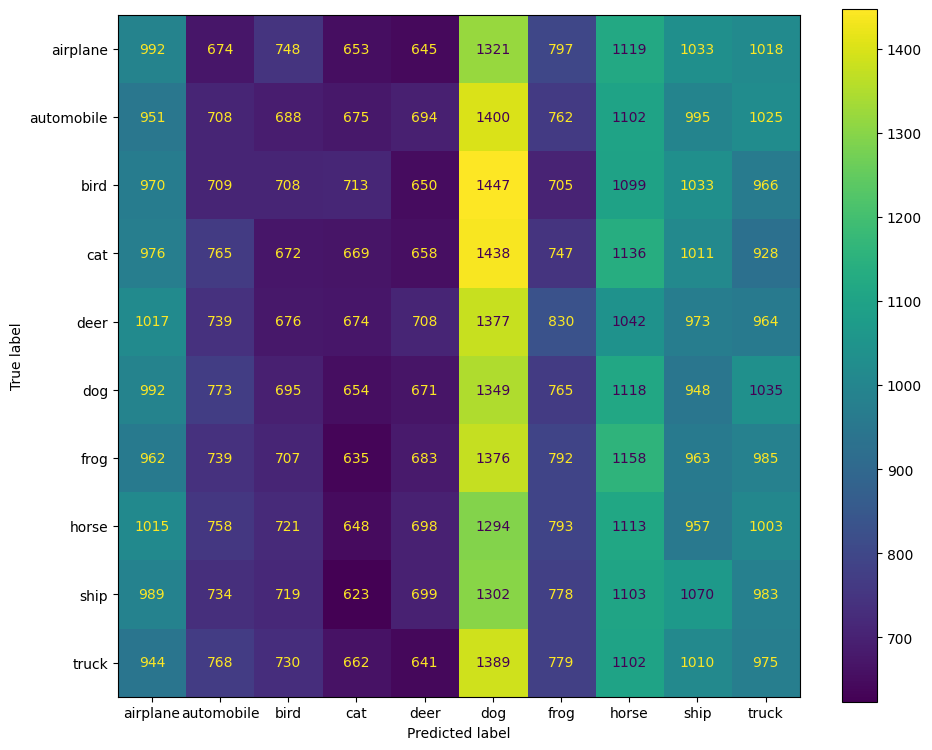

In [29]:
show_confusion_matrix(model1,test_ds,num_classes,class_names)

# VGG16 fine tuning

In [1]:
from tensorflow import keras

base_model = keras.applications.VGG16(
    weights='imagenet',
    input_shape=(32, 32, 3),
    include_top=False)

In [2]:
# Freeze base model
base_model.trainable = False

In [10]:
# Create inputs with correct shape
inputs = keras.Input(shape=(32, 32, 3))

x = base_model(inputs, training=False)

# Add pooling layer or flatten layer
x = keras.layers.GlobalAveragePooling2D()(x)

# Add final dense layer
outputs = keras.layers.Dense(num_classes, activation = 'softmax')(x)

# Combine inputs and outputs to create model
model = keras.Model(inputs,outputs)

In [40]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 global_average_pooling2d_3   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 10)                5130      
                                                                 
Total params: 20,029,514
Trainable params: 5,130
Non-trainable params: 20,024,384
_________________________________________________________________


In [17]:
model.compile(loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [18]:
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history = model.fit(train_ds,
          validation_data=validation_ds,
          epochs=20,
          callbacks=[callback]
        )

Epoch 1/20
4500/4500 [==============================] - 44s 8ms/step - loss: 5.2093 - categorical_accuracy: 0.3752 - val_loss: 3.0708 - val_categorical_accuracy: 0.3977
Epoch 2/20
4500/4500 [==============================] - 33s 7ms/step - loss: 3.0886 - categorical_accuracy: 0.4041 - val_loss: 3.0042 - val_categorical_accuracy: 0.4011
Epoch 3/20
4500/4500 [==============================] - 34s 8ms/step - loss: 3.0955 - categorical_accuracy: 0.4031 - val_loss: 3.0556 - val_categorical_accuracy: 0.3999
Epoch 4/20
4500/4500 [==============================] - 33s 7ms/step - loss: 3.1136 - categorical_accuracy: 0.4037 - val_loss: 3.2000 - val_categorical_accuracy: 0.3998
Epoch 5/20
4500/4500 [==============================] - 33s 7ms/step - loss: 3.1223 - categorical_accuracy: 0.4053 - val_loss: 3.0269 - val_categorical_accuracy: 0.4119


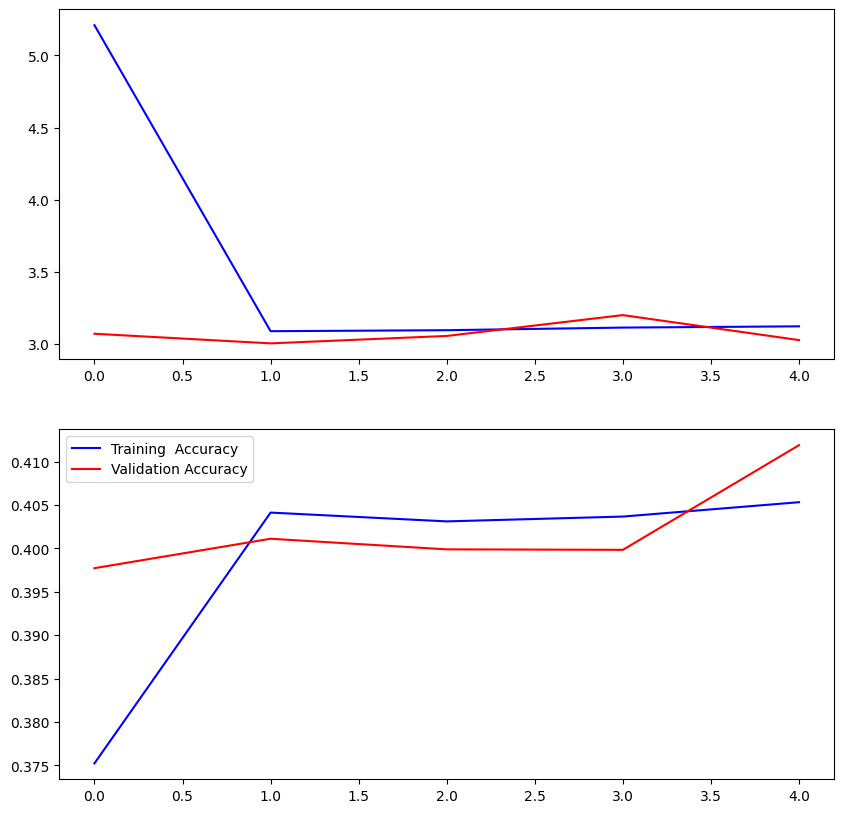

In [20]:
f,ax=plt.subplots(2,1,figsize=(10,10)) 

#Assigning the first subplot to graph training loss and validation loss
ax[0].plot(model.history.history['loss'],color='b',label='Training Loss')
ax[0].plot(model.history.history['val_loss'],color='r',label='Validation Loss')

#Plotting the training accuracy and validation accuracy
ax[1].plot(model.history.history['categorical_accuracy'],color='b',label='Training  Accuracy')
ax[1].plot(model.history.history['val_categorical_accuracy'],color='r',label='Validation Accuracy')

plt.legend()  

In [21]:
# Unfreeze the base model
base_model.trainable = True

# Compile the model with a low learning rate
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate = .00001),
              loss = 'categorical_crossentropy' , metrics = ['categorical_accuracy'])

In [22]:
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history = model.fit(train_ds,
          validation_data=validation_ds,
          epochs=10,
          callbacks=[callback]
)

Epoch 1/10
4500/4500 [==============================] - 64s 14ms/step - loss: 1.2052 - categorical_accuracy: 0.5757 - val_loss: 1.0882 - val_categorical_accuracy: 0.6198
Epoch 2/10
4500/4500 [==============================] - 62s 14ms/step - loss: 0.9592 - categorical_accuracy: 0.6624 - val_loss: 0.9857 - val_categorical_accuracy: 0.6592
Epoch 3/10
4500/4500 [==============================] - 64s 14ms/step - loss: 0.8864 - categorical_accuracy: 0.6920 - val_loss: 1.0146 - val_categorical_accuracy: 0.6523
Epoch 4/10
4500/4500 [==============================] - 64s 14ms/step - loss: 0.8604 - categorical_accuracy: 0.7028 - val_loss: 0.9758 - val_categorical_accuracy: 0.6706
Epoch 5/10
4500/4500 [==============================] - 63s 14ms/step - loss: 0.8522 - categorical_accuracy: 0.7058 - val_loss: 1.0196 - val_categorical_accuracy: 0.6734
Epoch 6/10
4500/4500 [==============================] - 63s 14ms/step - loss: 0.8549 - categorical_accuracy: 0.7060 - val_loss: 1.0219 - val_categoric

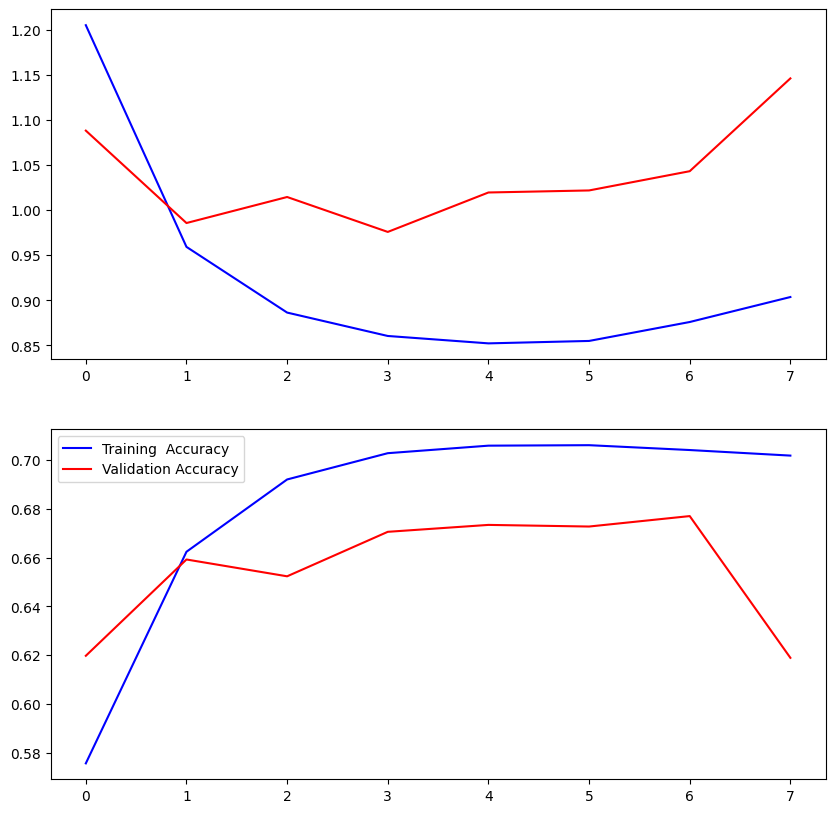

In [23]:
f,ax=plt.subplots(2,1,figsize=(10,10)) 

#Assigning the first subplot to graph training loss and validation loss
ax[0].plot(model.history.history['loss'],color='b',label='Training Loss')
ax[0].plot(model.history.history['val_loss'],color='r',label='Validation Loss')

#Plotting the training accuracy and validation accuracy
ax[1].plot(model.history.history['categorical_accuracy'],color='b',label='Training  Accuracy')
ax[1].plot(model.history.history['val_categorical_accuracy'],color='r',label='Validation Accuracy')

plt.legend()

In [24]:
model.evaluate(validation_ds)

1125/1125 [==============================] - 6s 6ms/step - loss: 1.1461 - categorical_accuracy: 0.6189


[1.1461471319198608, 0.6189444661140442]

# Committee

In [11]:
tf.random.set_seed(313)
class_number = len(class_names)
model_number = 3 # 3 classes, 3 classes, 4 classes
start_class = 0
end_class = 3
committee_models_1 = []

for i in range(model_number):
    # Determine and filter the subset of classes for this model
    subset_classes = class_names[start_class:end_class]
    
    subset_dataset_train = train_ds.filter(lambda x, y: tf.reduce_any([tf.equal(y, 
                    tf.one_hot(class_names.index(class_name), depth=len(class_names))) for class_name in subset_classes]))
    
    subset_dataset_val = validation_ds.filter(lambda x, y: tf.reduce_any([tf.equal(y, 
                    tf.one_hot(class_names.index(class_name), depth=len(class_names))) for class_name in subset_classes]))

    # Create, compile and train the models for the current subset of classes
    # Then add to the proper committee
    
    # Model1
    model1 = create_Architecture1()
    model1.compile(loss=loss_func,metrics=metrics)
    
    callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
    history = model1.fit(
        subset_dataset_train,
        validation_data=subset_dataset_val, 
        epochs=20, 
        callbacks = [callback]
    )
    
    committee_models_1.append(model1)
    
    # Update start/end index
    start_class = start_class+3
    end_class = start_class+3
    if end_class == class_number - 1:
        end_class = class_number

Epoch 1/20
5625/5625 [==============================] - 92s 15ms/step - loss: 1.5271 - categorical_accuracy: 0.4486 - auc: 0.8660 - precision: 0.6179 - recall: 0.2709 - val_loss: 1.5981 - val_categorical_accuracy: 0.4380 - val_auc: 0.8609 - val_precision: 0.5678 - val_recall: 0.3185
Epoch 2/20
5625/5625 [==============================] - 75s 13ms/step - loss: 1.2174 - categorical_accuracy: 0.5620 - auc: 0.9156 - precision: 0.7155 - recall: 0.4091 - val_loss: 1.5829 - val_categorical_accuracy: 0.4552 - val_auc: 0.8608 - val_precision: 0.6060 - val_recall: 0.3304
Epoch 3/20
5625/5625 [==============================] - 75s 13ms/step - loss: 1.1069 - categorical_accuracy: 0.6056 - auc: 0.9303 - precision: 0.7412 - recall: 0.4708 - val_loss: 1.1884 - val_categorical_accuracy: 0.5790 - val_auc: 0.9198 - val_precision: 0.7150 - val_recall: 0.4509
Epoch 4/20
5625/5625 [==============================] - 74s 13ms/step - loss: 1.0344 - categorical_accuracy: 0.6302 - auc: 0.9390 - precision: 0.756

In [12]:
# Evaluating the committees

# Committee1
predictions = []
for model in committee_models_1:
    model_predictions = model.predict(test_ds)
    predictions.append(model_predictions)
    
combined_predictions_1 = np.mean(predictions, axis=0)  # Average predictions
predicted_labels_1 = np.argmax(combined_predictions_1, axis=1) # Mapping to labels


5625/5625 [==============================] - 20s 4ms/step


In [15]:
accuracy_1 = accuracy_score(tf_labels, predicted_labels_1)
precision_1 = precision_score(tf_labels, predicted_labels_1, average='weighted')
recall_1 = recall_score(tf_labels, predicted_labels_1, average='weighted')
f1_1 = f1_score(tf_labels, predicted_labels_1, average='weighted')

print("Accuracy 1:", accuracy_1)
print("Precision 1:", precision_1)
print("Recall 1:", recall_1)
print("F1 Score 1:", f1_1)

Accuracy 1: 0.10362222222222223
Precision 1: 0.10358160633634947
Recall 1: 0.10362222222222223
F1 Score 1: 0.09947075607503136


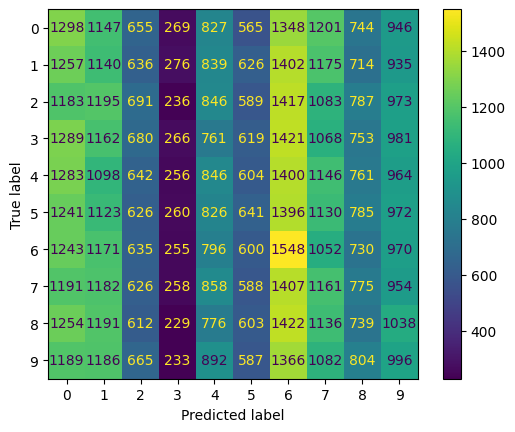

In [19]:
ConfusionMatrixDisplay.from_predictions(y_true=tf_labels, y_pred=predicted_labels_1)

In [20]:
class_number = len(class_names)
model_number = 3 # 3 classes, 3 classes, 4 classes
start_class = 0
end_class = 3
committee_models_2 = []

for i in range(model_number):
    # Determine and filter the subset of classes for this model
    subset_classes = class_names[start_class:end_class]
    
    subset_dataset_train = train_ds.filter(lambda x, y: tf.reduce_any([tf.equal(y, 
                    tf.one_hot(class_names.index(class_name), depth=len(class_names))) for class_name in subset_classes]))
    
    subset_dataset_val = validation_ds.filter(lambda x, y: tf.reduce_any([tf.equal(y, 
                    tf.one_hot(class_names.index(class_name), depth=len(class_names))) for class_name in subset_classes]))

    # Create, compile and train the models for the current subset of classes
    # Then add to the proper committee
    
    # Model2
    model2 = create_Architecture2()
    model2.compile(loss=loss_func,metrics=metrics)
    history = model2.fit(
        subset_dataset_train,
        validation_data=subset_dataset_val, 
        epochs=20, 
        callbacks = [callback]
    )
    committee_models_2.append(model2)
    
    # Update start/end index
    start_class = start_class+3
    end_class = start_class+3
    if end_class == class_number - 1:
        end_class = class_number

Epoch 1/20
5625/5625 [==============================] - 76s 13ms/step - loss: 1.6893 - categorical_accuracy: 0.3898 - auc: 0.8307 - precision: 0.6092 - recall: 0.1649 - val_loss: 1.4287 - val_categorical_accuracy: 0.4803 - val_auc: 0.8821 - val_precision: 0.6879 - val_recall: 0.2722
Epoch 2/20
5625/5625 [==============================] - 73s 13ms/step - loss: 1.3657 - categorical_accuracy: 0.5032 - auc: 0.8928 - precision: 0.6936 - recall: 0.3102 - val_loss: 1.3014 - val_categorical_accuracy: 0.5313 - val_auc: 0.9036 - val_precision: 0.7457 - val_recall: 0.3160
Epoch 3/20
5625/5625 [==============================] - 73s 13ms/step - loss: 1.2653 - categorical_accuracy: 0.5421 - auc: 0.9085 - precision: 0.7148 - recall: 0.3681 - val_loss: 1.2632 - val_categorical_accuracy: 0.5445 - val_auc: 0.9089 - val_precision: 0.7150 - val_recall: 0.3679
Epoch 4/20
5625/5625 [==============================] - 73s 13ms/step - loss: 1.2078 - categorical_accuracy: 0.5650 - auc: 0.9168 - precision: 0.725

In [21]:
# Evaluating the committees

# Committee2
predictions = []
for model in committee_models_2:
    model_predictions = model.predict(test_ds)
    predictions.append(model_predictions)
    
combined_predictions_2 = np.max(predictions, axis=0)  
predicted_labels_2 = np.argmax(combined_predictions_2, axis=1)

5625/5625 [==============================] - 18s 3ms/step


In [22]:
accuracy_2 = accuracy_score(tf_labels, predicted_labels_2)
precision_2 = precision_score(tf_labels, predicted_labels_2, average='weighted')
recall_2 = recall_score(tf_labels, predicted_labels_2, average='weighted')
f1_2 = f1_score(tf_labels, predicted_labels_2, average='weighted')

print("Accuracy 2:", accuracy_2)
print("Precision 2:", precision_2)
print("Recall 2:", recall_2)
print("F1 Score 2:", f1_2)

Accuracy 2: 0.10311111111111111
Precision 2: 0.10373846801025524
Recall 2: 0.10311111111111111
F1 Score 2: 0.09696404247806598


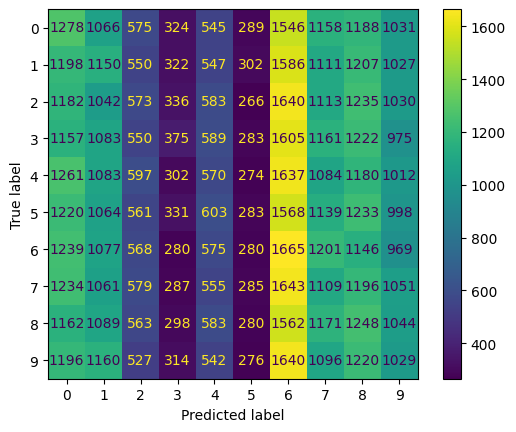

In [23]:
ConfusionMatrixDisplay.from_predictions(tf_labels, predicted_labels_2)

In [24]:
class_number = len(class_names) 
model_number = 3 # 3 classes, 3 classes, 4 classes
start_class = 0
end_class = 3
committee_models_3 = []

for i in range(model_number):
    # Determine and filter the subset of classes for this model
    subset_classes = class_names[start_class:end_class]
    
    subset_dataset_train = train_ds.filter(lambda x, y: tf.reduce_any([tf.equal(y, 
                    tf.one_hot(class_names.index(class_name), depth=len(class_names))) for class_name in subset_classes]))
    
    subset_dataset_val = validation_ds.filter(lambda x, y: tf.reduce_any([tf.equal(y, 
                    tf.one_hot(class_names.index(class_name), depth=len(class_names))) for class_name in subset_classes]))

    # Create, compile and train the models for the current subset of classes
    # Then add to the proper committee
    
    # Model3
    model3 = create_Architecture3()
    model3.compile(loss=loss_func,metrics=metrics)
    history = model3.fit(
        subset_dataset_train,
        validation_data=subset_dataset_val, 
        epochs=20, 
        callbacks = [callback]
    )
    committee_models_3.append(model2)
    
    # Update start/end index
    start_class = start_class+3
    end_class = start_class+3
    if end_class == class_number - 1:
        end_class = class_number

Epoch 1/20
5625/5625 [==============================] - 85s 15ms/step - loss: 1.7506 - categorical_accuracy: 0.3419 - auc: 0.8132 - precision: 0.5805 - recall: 0.1143 - val_loss: 1.5843 - val_categorical_accuracy: 0.4043 - val_auc: 0.8532 - val_precision: 0.6155 - val_recall: 0.1882
Epoch 2/20
5625/5625 [==============================] - 82s 15ms/step - loss: 1.5226 - categorical_accuracy: 0.4352 - auc: 0.8653 - precision: 0.6312 - recall: 0.2217 - val_loss: 1.4611 - val_categorical_accuracy: 0.4619 - val_auc: 0.8774 - val_precision: 0.6357 - val_recall: 0.2870
Epoch 3/20
5625/5625 [==============================] - 84s 15ms/step - loss: 1.4405 - categorical_accuracy: 0.4678 - auc: 0.8804 - precision: 0.6603 - recall: 0.2710 - val_loss: 1.4270 - val_categorical_accuracy: 0.4794 - val_auc: 0.8829 - val_precision: 0.6569 - val_recall: 0.2984
Epoch 4/20
5625/5625 [==============================] - 83s 15ms/step - loss: 1.3941 - categorical_accuracy: 0.4876 - auc: 0.8886 - precision: 0.670

In [25]:
# Evaluating the committees

# Committee3
predictions = []
for model in committee_models_3:
    model_predictions = model.predict(test_ds)
    predictions.append(model_predictions)
    
combined_predictions_3 = np.max(predictions, axis=0)  
predicted_labels_3 = np.argmax(combined_predictions_3, axis=1)

5625/5625 [==============================] - 18s 3ms/step


In [26]:
accuracy_3 = accuracy_score(tf_labels, predicted_labels_3)
precision_3 = precision_score(tf_labels, predicted_labels_3, average='weighted')
recall_3 = recall_score(tf_labels, predicted_labels_3, average='weighted')
f1_3 = f1_score(tf_labels, predicted_labels_3, average='weighted')

print("Accuracy 3:", accuracy_3)
print("Precision 3:", precision_3)
print("Recall 3:", recall_3)
print("F1 Score 3:", f1_3)

Accuracy 3: 0.10237777777777778
Precision 3: 0.10356067465564975
Recall 3: 0.10237777777777778
F1 Score 3: 0.09716829558082297


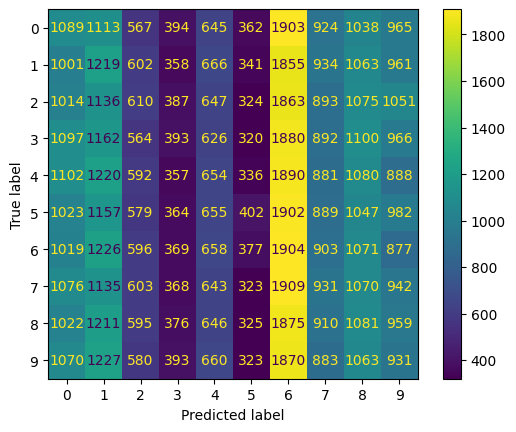

In [27]:
ConfusionMatrixDisplay.from_predictions(tf_labels, predicted_labels_3)